# Food Score Analysis

I picked food score as my metric - which neighborhood has the most places to get food.

## Datasets Used

**1.** `food_facilities.csv`: Contains restaurant information and their coordinates

**2.** `Neighborhoods_.geojson`: It is used to match each restaurant coordinate to its exact neighborhood


In [16]:
import pandas as pd
import geopandas as gpd

# Load the food facilities data
df = pd.read_csv('food_facilities.csv')

# Filter for active restaurants (status == 1 means active)
df_active = df[df['status'] == 1]

# Filter for restaurants only (category codes starting with 2 are restaurants)
# 201: Restaurant with Liquor, 211: Restaurant without Liquor, 212: Chain Restaurant without Liquor
restaurant_codes = [201, 211, 212]
df_restaurants = df_active[df_active['category_cd'].isin(restaurant_codes)]

# Keep only the required columns
df_clean = df_restaurants[['facility_name', 'x', 'y', 'address']].copy()

# Remove rows with missing coordinates
df_clean = df_clean.dropna(subset=['x', 'y'])

print(f"Total restaurants: {len(df_clean)}")
print(f"\nFirst few rows:")
df_clean.head()


Total restaurants: 3545

First few rows:


,facility_name,x,y,address
71,The Sewickley SpeakEasy,-80.157420,40.526244,17 Ohio River Boulevard PA 15143
87,Rookies' Bar,-79.975246,40.373361,3619 Brownsville Rd PA 15227
93,Barnes & Noble Booksellers #2898,-79.893598,40.488894,926 Freeport Road PA 15238
105,Nico's Recovery Room,-79.948935,40.463685,178 Pearl St PA 15224
108,Capri Pizza,-79.721334,40.627053,2103 Freeport Road PA 15065


In [17]:
#save the cleaned data to a new CSV
df_clean.to_csv('food_facilities_clean.csv', index=False)

# Load neighborhood boundaries
neighborhoods = gpd.read_file('Neighborhoods_.geojson')

# Convert restaurant dataframe to GeoDataFrame with Point geometries
gdf_restaurants = gpd.GeoDataFrame(
    df_clean,
    geometry=gpd.points_from_xy(df_clean.x, df_clean.y),
    crs='EPSG:4326'  # WGS84 coordinate system
)

# Spatial join: match each restaurant to its neighborhood
restaurants_with_neighborhood = gpd.sjoin(
    gdf_restaurants, 
    neighborhoods[['geometry', 'hood']], 
    how='left', 
    predicate='within'
)

# Clean up: keep only relevant columns
restaurants_final = restaurants_with_neighborhood[['facility_name', 'x', 'y', 'address', 'hood']].copy()
restaurants_final.rename(columns={'hood': 'neighborhood'}, inplace=True)

# Remove restaurants that didn't match any neighborhood
restaurants_final = restaurants_final.dropna(subset=['neighborhood'])

print(f"Restaurants matched to neighborhoods: {len(restaurants_final)}")
print(f"\nSample data:")
restaurants_final.head()


Restaurants matched to neighborhoods: 1389

Sample data:


,facility_name,x,y,address,neighborhood
93,Barnes & Noble Booksellers #2898,-79.893598,40.488894,926 Freeport Road PA 15238,Lincoln-Lemington-Belmar
105,Nico's Recovery Room,-79.948935,40.463685,178 Pearl St PA 15224,Bloomfield
138,Buon Giorno Cafe,-80.005176,40.438665,20 Stanwix Street PA 15222,Central Business District
207,Fiori's Pizzaria,-80.018446,40.405176,103 Capital Avenue PA 15226,Brookline
242,Don's Diner,-80.037329,40.471623,1729 Eckert St PA 15212,Marshall-Shadeland


In [18]:
# Calculate food score: count restaurants per neighborhood
food_score = restaurants_final.groupby('neighborhood').size().reset_index(name='food_score')
food_score = food_score.sort_values('food_score', ascending=False)


food_score.head(10)


,neighborhood,food_score
12,Central Business District,175
57,South Side Flats,102
44,North Shore,83
43,North Oakland,76
15,Central Oakland,68
53,Shadyside,67
62,Strip District,66
6,Bloomfield,66
61,Squirrel Hill South,62
13,Central Lawrenceville,55


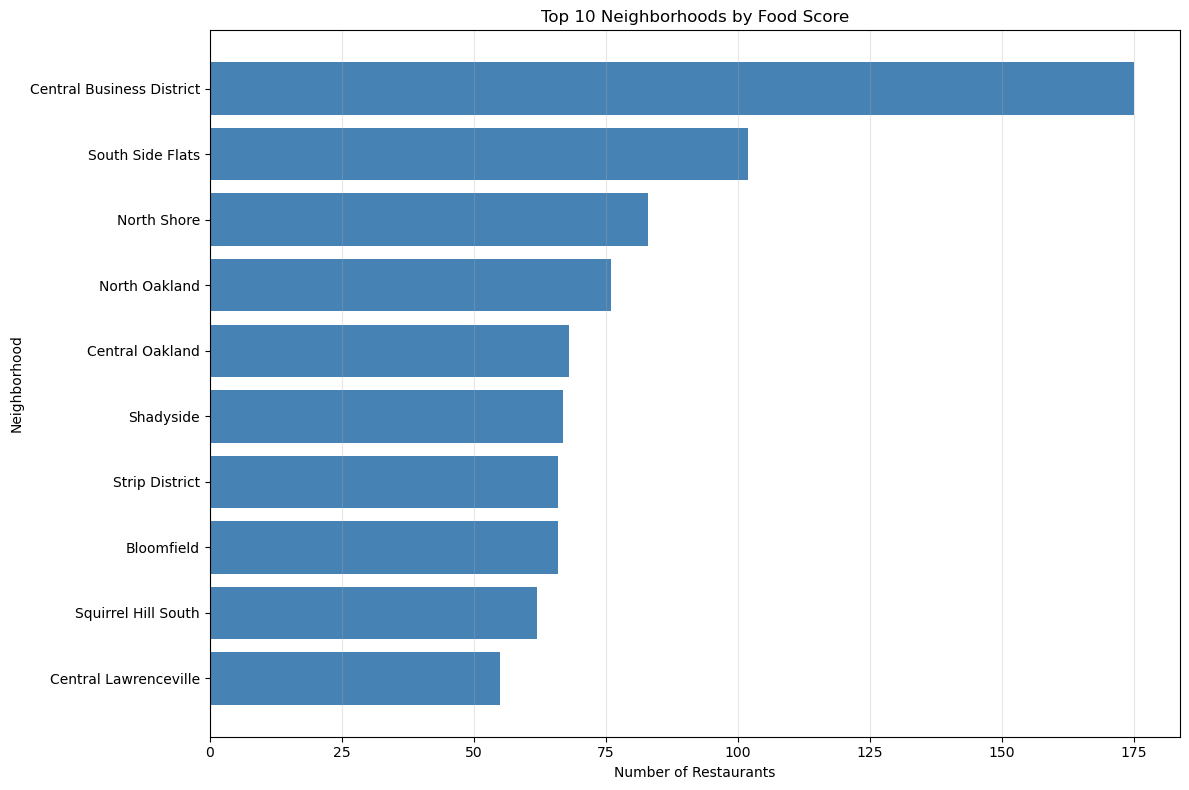

In [ ]:
import matplotlib.pyplot as plt

# bar chart for top 10 neighborhoods
n = 10
top_neighborhoods = food_score.head(n)

plt.figure(figsize=(12, 8))
plt.barh(top_neighborhoods['neighborhood'], top_neighborhoods['food_score'], color='steelblue')
plt.xlabel('Number of Restaurants')
plt.ylabel('Neighborhood')
plt.title(f'Top {n} Neighborhoods by Food Score')
plt.gca().invert_yaxis()  
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


Overall, I would say Central Bussiness District is the best nieghborhood because it has most places to get food.